In [1]:
!pip install -q sentencepiece

import sentencepiece as spm
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Sabit sonuçlar için
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
df = pd.read_json("/kaggle/input/turkish-joke-dataset/dataset.json")
df = df.dropna(subset=["text"])
df = df[df["text"].str.strip() != ""]

with open("fikralar.txt", "w", encoding="utf-8") as f:
    for line in df["text"]:
        f.write(line.strip().replace("\n", " ") + "\n")

In [3]:
spm.SentencePieceTrainer.train(
    input='fikralar.txt',
    model_prefix='fikra_tokenizer',
    vocab_size=3000,
    model_type='unigram',
    character_coverage=0.9995
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: fikralar.txt
  input_format: 
  model_prefix: fikra_tokenizer
  model_type: UNIGRAM
  vocab_size: 3000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0


In [4]:
class TransformerFikra(nn.Module):
    def __init__(self, vocab_size, emb_dim=512, n_heads=8, n_layers=8, max_len=512):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim)
        self.pos_embed = nn.Embedding(max_len, emb_dim)
        self.layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dropout=0.1),  # <--- Dropout eklendi
            num_layers=n_layers
        )
        self.fc = nn.Linear(emb_dim, vocab_size)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        x = self.embed(x) + self.pos_embed(positions)
        x = self.layers(x)
        return self.fc(x)

In [5]:
class FikraDataset(Dataset):
    def __init__(self, path, tokenizer_path, block_size=512):  
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(tokenizer_path)
        with open(path, encoding='utf-8') as f:
            text = f.read()
        ids = self.tokenizer.encode(text)
        self.examples = [ids[i:i+block_size] for i in range(0, len(ids)-block_size, block_size)]

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        x = torch.tensor(self.examples[idx], dtype=torch.long)
        y = torch.tensor(self.examples[idx][1:] + [0], dtype=torch.long)
        return x, y


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

full_dataset = FikraDataset('fikralar.txt', 'fikra_tokenizer.model')
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [7]:
model = TransformerFikra(
    vocab_size=6000,
    emb_dim=512,
    n_heads=8,
    n_layers=8
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

# 🧠 Learning Rate Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.3, verbose=True)


In [8]:
train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(50):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            val_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)  # <--- Öğrenme oranı güncelleniyor

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("📌 En iyi model kaydedildi!")

Epoch 1 | Train Loss: 7.6627 | Val Loss: 7.0974
📌 En iyi model kaydedildi!
Epoch 2 | Train Loss: 6.9213 | Val Loss: 6.8337
📌 En iyi model kaydedildi!
Epoch 3 | Train Loss: 6.8028 | Val Loss: 6.8017
📌 En iyi model kaydedildi!
Epoch 4 | Train Loss: 6.7813 | Val Loss: 6.7891
📌 En iyi model kaydedildi!
Epoch 5 | Train Loss: 6.7714 | Val Loss: 6.7830
📌 En iyi model kaydedildi!
Epoch 6 | Train Loss: 6.7154 | Val Loss: 6.6645
📌 En iyi model kaydedildi!
Epoch 7 | Train Loss: 6.5762 | Val Loss: 6.5399
📌 En iyi model kaydedildi!
Epoch 8 | Train Loss: 6.4123 | Val Loss: 6.4060
📌 En iyi model kaydedildi!
Epoch 9 | Train Loss: 6.2462 | Val Loss: 6.2629
📌 En iyi model kaydedildi!
Epoch 10 | Train Loss: 6.0741 | Val Loss: 6.1282
📌 En iyi model kaydedildi!
Epoch 11 | Train Loss: 5.9097 | Val Loss: 6.0053
📌 En iyi model kaydedildi!
Epoch 12 | Train Loss: 5.7663 | Val Loss: 5.8953
📌 En iyi model kaydedildi!
Epoch 13 | Train Loss: 5.6329 | Val Loss: 5.8001
📌 En iyi model kaydedildi!
Epoch 14 | Train Loss

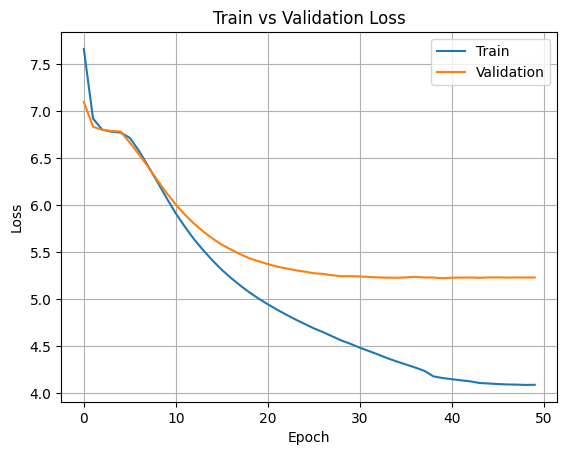

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from torch.nn import functional as F

def sample_logits(logits, temperature=1.2, top_k=60):
    logits = logits / temperature
    top_k = min(top_k, logits.size(-1))
    values, _ = torch.topk(logits, top_k)
    min_values = values[:, -1].unsqueeze(1)
    logits[logits < min_values] = -float("Inf")
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()


In [11]:
from torch.nn import functional as F

def sample_top_p(logits, temperature=1.0, top_p=0.9):
    logits = logits / temperature
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    # top_p dışındaki her şeyi -inf yap
    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    logits[sorted_indices[sorted_indices_to_remove]] = -float("Inf")
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).item()


In [13]:
tokenizer = spm.SentencePieceProcessor()
tokenizer.load("fikra_tokenizer.model")

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.to(device)
model.eval()

input_text = "Fıkra:"
input_ids = tokenizer.encode(input_text)
input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

generated = input_tensor

for _ in range(100):
    with torch.no_grad():
        output = model(generated)
    logits = output[0, -1]
    next_token = sample_top_p(logits, temperature=1.3, top_p=0.92)  
    generated = torch.cat([generated, torch.tensor([[next_token]], device=device)], dim=1)
    if next_token == tokenizer.eos_id():
        break

output_text = tokenizer.decode(generated[0].tolist())
output_text = output_text.replace("�", "").replace("⁇", "").replace("\uFFFD", "")  # bozuk karakterleri sil
print("\n🎉 Üretilen Fıkra:\n")
print(output_text)

/tmp/ipykernel_31/4037634659.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt", map_location=device))



🎉 Üretilen Fıkra:

Fıkra:lmayacak eşis ve fi diye neredesek kimturdun aldığı oturmadan çocuğu yağmuraaha maret adam karşılık yerine yok o yap nasıl yolda giderken ön dışarıda 30erinedın doğru; hiçHa yeniınca geçti kafa yüzdeyorlardik, önce yiyorça istedimak bas şu bir merakU yüzün; - Bana tahminn doktor görmüşki boş bizim dört hırsızına yeterlara kim abdest olma yaz’ Albay i olduğununden hepLAR vayakÖyleyse buldukten doğu hiç köy ça Hoca kendini tane
